# Synthetic data export

This notebook extracts 9 time-series traces from the LBNL AlphaBuilding Synthetic Dataset in the format required by the energy data observatory, i.e. hourly time series with metadata table.

See: https://lbnl-eta.github.io/AlphaBuilding-SyntheticDataset/

Adapted from: https://github.com/LBNL-ETA/AlphaBuilding-SyntheticDataset/blob/master/A%20Synthetic%20Operation%20Dataset.ipynb

In [6]:
# Libraries used in this notebook
import pandas as pd
import numpy as np
import h5py
import os
import datetime



In [104]:
# to obtain the file: `aws s3 cp s3://oedi-data-lake/building_synthetic_dataset/A_Synthetic_Building_Operation_Dataset.h5 <local_directory> --no-sign-request`
dir_to_HDF = '/app/test_data/A_Synthetic_Building_Operation_Dataset.h5'
hdf = h5py.File(dir_to_HDF, 'r')

In [96]:
def get_df_from_hdf(hdf, climate='1A', efficiency='High', year='TMY3', str_run='run_1', data_key='ZonePeopleOccupantCount'):
    '''
    This function extracts the dataframe from the all run hdf5 file
    '''
    ts_root = hdf.get('3. Data').get('3.2. Timeseries')
    sub = ts_root.get(climate).get(efficiency).get(year).get(str_run).get(data_key)
    cols = np.array(sub.get('axis0'))[1:].astype(str)
    data = np.array(sub.get('block1_values'))
    df = pd.DataFrame(data, columns = cols)
    df.index = [ts.strftime('%Y-%m-%d %H:%M:%S') for ts in pd.date_range('2006-01-01', '2007-01-01', freq='10min')[:-1]]
    return df

def get_elec_hourly(hdf, climate='1A', efficiency='High', year='TMY3', str_run='run_1'):
    df = get_df_from_hdf(hdf, climate=climate, efficiency=efficiency, year=year, str_run=str_run, data_key='ElectricityFacility')
    df = df.reset_index().rename(columns={'index':'datetime'})
    df['datetime'] = pd.to_datetime(df['datetime']).dt.round('h')
    J_to_kWh = 1/3600000
    df['electricity_kwh'] = df['Electricity:Facility[J]'] * J_to_kWh
    del df['Electricity:Facility[J]']
    df['run'] = str_run
    df['climate'] = climate
    df['efficiency'] = efficiency
   # df = df.groupby(['datetime', 'climate', 'efficiency', 'run']).sum().reset_index()
    return(df)

def fetch_all(hdf):
    dfs = []
    climates = [str(k) for k in hdf.get('3. Data').get('3.2. Timeseries').keys()]
    efficiencies = [str(k) for k in hdf.get('3. Data').get('3.2. Timeseries').get(climates[0]).keys()]    
    for climate in climates:
        for efficiency in efficiencies:            
                dfs.append(get_elec_hourly(hdf, climate=climate, efficiency=efficiency, year='TMY3', str_run='run_1'))
    df_all = pd.concat(dfs)
    return df_all



In [99]:
df = fetch_all(hdf)

In [106]:
df['meter_id'] = df['climate'] + '_' + df['efficiency']
df_ts = df[['datetime', 'meter_id', 'electricity_kwh']]
df_meta = df[['meter_id', 'climate', 'efficiency']].drop_duplicates()
df_ts.to_csv('meter_time_series.csv')
df_meta.to_csv('meter_metadata.csv')

In [111]:
df_ts

,datetime,meter_id,electricity_kwh
0,2006-01-01 00:00:00,1A_High,5.223701
1,2006-01-01 00:00:00,1A_High,6.548759
2,2006-01-01 00:00:00,1A_High,6.461732
3,2006-01-01 00:00:00,1A_High,4.400911
4,2006-01-01 01:00:00,1A_High,6.570105
...,...,...,...
52555,2006-12-31 23:00:00,5A_Standard,7.123587
52556,2006-12-31 23:00:00,5A_Standard,6.195013
52557,2007-01-01 00:00:00,5A_Standard,6.940542
52558,2007-01-01 00:00:00,5A_Standard,5.673104


In [112]:
df_meta

,meter_id,climate,efficiency
0,1A_High,1A,High
0,1A_Low,1A,Low
0,1A_Standard,1A,Standard
0,3C_High,3C,High
0,3C_Low,3C,Low
0,3C_Standard,3C,Standard
0,5A_High,5A,High
0,5A_Low,5A,Low
0,5A_Standard,5A,Standard


# Display results

The plot below plots aveage hourly load shapes for each of the nine time series.  The first plot is the average load shape across the entire timespan, while the second is the average load shape in each month.  The plots look reasonable and correct.

In [101]:
df['hour'] = df.datetime.dt.hour
df_plot = df.groupby(['hour', 'climate', 'efficiency']).mean().reset_index()

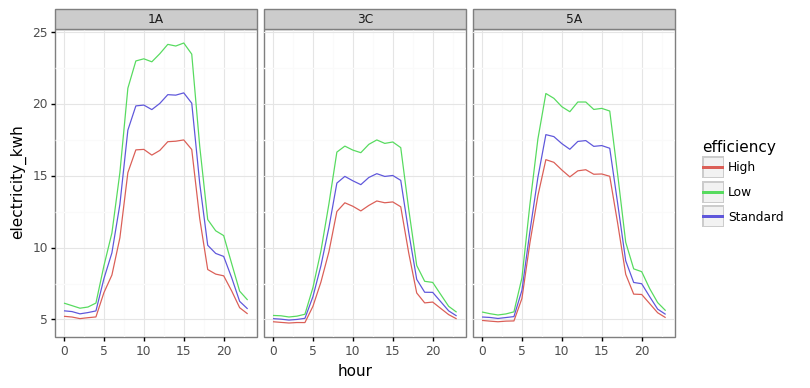

<ggplot: (8733813129669)>

In [103]:
import plotnine as p9
p9.options.figure_size = (8,4)
p9.ggplot(df_plot, p9.aes(x='hour', y='electricity_kwh', color='efficiency', group='efficiency')) + p9.geom_line() + p9.facet_wrap("~climate") + p9.theme_bw()

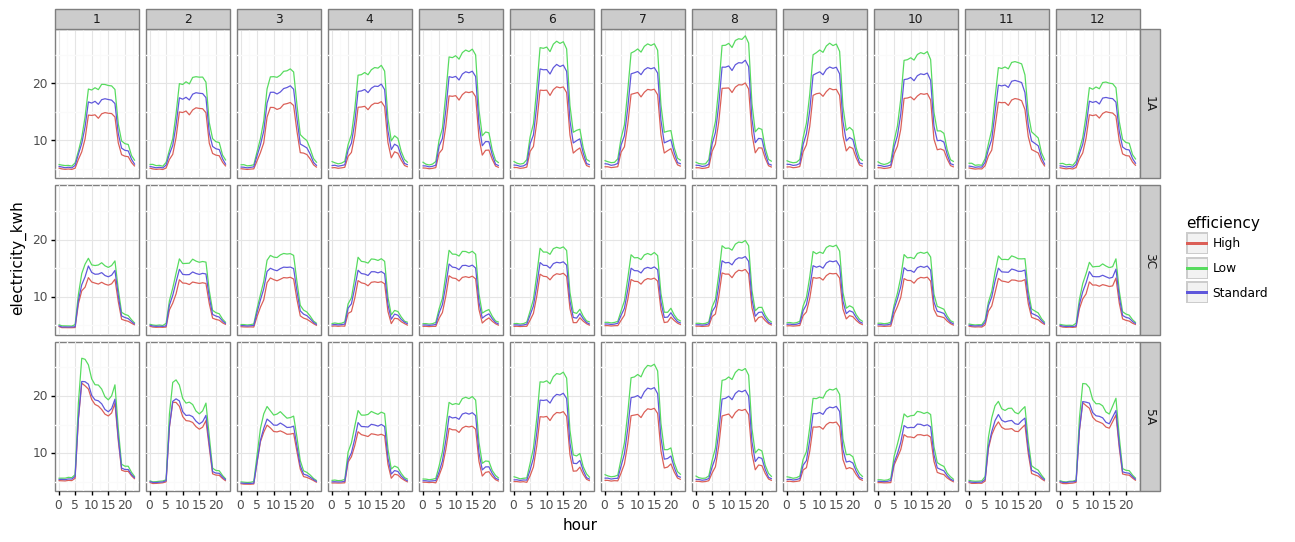

<ggplot: (8733801014013)>

In [115]:
df['month'] = df.datetime.dt.month
df_plot = df.groupby(['hour', 'month', 'climate', 'efficiency']).mean().reset_index()
p9.options.figure_size = (14,6)
p9.ggplot(df_plot, p9.aes(x='hour', y='electricity_kwh', color='efficiency', group='efficiency')) + p9.geom_line() + p9.facet_grid("climate~month") + p9.theme_bw()